In [1]:
# > Load packages ----
#require(dplyr); require(ggplot2); require(gridExtra); require(scales)
import pandas as pd
import numpy as np
import re
import os
import fnmatch
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

#from matplotlib import pyplot as plt
from matplotlib import pylab
pylab.style.use('ggplot') 
%matplotlib inline

In [55]:
# helper
def list_files(directory, pattern):
    all_files = os.listdir(directory) 
    relevant_files = []
    for entry in all_files:  
        if fnmatch.fnmatch(entry, pattern):
            #print (entry)
            relevant_files.append(entry)
    return relevant_files
# main functions
def create_datasets(LOOPING_LIST, PARENT):
    data_dict = dict()
    ## start loop
    for i in list(LOOPING_LIST):
        if i == 'Quarantine':
            file_naming = 'Flag_Freqs'
        else:
            file_naming = 'Strata'
        
        # take the most recently dated input file and use this date as the 'date' column and new column name
        CURR_LIST = [PARENT + i + '/' + f for f in sorted(list_files(PARENT + i, "*.csv"), reverse = True)]
        most_recent_csv_filename = CURR_LIST[0]
        input_date = datetime.strptime(re.findall(r'\d{6,}$', re.sub('.csv$','',most_recent_csv_filename))[0],'%Y%m%d').date()
        
        CURR_IMPORT = pd.read_csv(most_recent_csv_filename)
        # weird columns coming through - not sure if this is a marissa problem
        CURR_IMPORT.drop(columns = CURR_IMPORT.columns[((CURR_IMPORT.columns.str.contains('Unnamed')) | (CURR_IMPORT.columns == 'X'))], inplace = True)
        CURR_IMPORT['date'] = input_date # add date column based on file date
        CURR_IMPORT.to_csv(most_recent_csv_filename) # rewrite file with new date column

        DATA = pd.DataFrame()
        for csv in CURR_LIST:
            df = pd.read_csv(csv)
            # weird columns coming through - not sure if this is a marissa problem
            df.drop(columns = df.columns[((df.columns.str.contains('Unnamed')) | (df.columns == 'X'))], inplace = True)
            df['date'] = datetime.strptime(re.findall(r'\d{6,}$', re.sub('.csv$','',csv))[0],'%Y%m%d').date()
            DATA = pd.concat([DATA, df], axis = 0)
            
        data_dict['raw_data_' + i ] = DATA
        if file_naming == 'Strata':
            # strata population and respondent
            strata = DATA[['date','pop_count', 'sample_count']].groupby('date').sum()
            final = pd.concat([pd.DataFrame({'date' : strata.index,
                                            'group' : 'Population',
                                            'sum' : strata['pop_count']}),
                              pd.DataFrame({'date' : strata.index,
                                            'group' : 'Sample',
                                            'sum': strata['sample_count']})],
                              axis = 0)
            data_dict[i + '_pop_resp'] = final

            # over 30 
            DATA['count'] = np.where(DATA['pop_count']>30, 1,0)
            pct_30 = DATA[['date','count']].groupby('date').agg({"count": {"over_30" : "sum",
                                                                           "total" : "count"}})['count']

            pct_30 = pd.DataFrame({'date' : pct_30.index,
                                   'group' : i + ' Strata > 30',
                                   'pct' : pct_30['over_30'] / pct_30['total']})
            data_dict[i + '_over_30'] = pct_30

            # over 20
            data_final = DATA[DATA['count']==1]
            data_final['over_20_pct'] = np.where(((data_final['pop_dist'] -
                                                   data_final['sample_dist']) /
                                                  data_final['pop_dist']) > .2, 1, 0)
            data_final = data_final[['date','over_20_pct']].groupby('date').agg({"over_20_pct":{"over_20" : "sum",
                                                                                   "total" : "count"}})['over_20_pct']

            data_final = pd.DataFrame({'date' : data_final.index,
                                       'group' : i,
                                       'pct' : data_final['over_20'] / data_final['total']})
            data_dict[i + '_over_20'] = data_final
            ### add plotting

        ## check   
        elif file_naming == 'Flag_Freqs':
            ## add plotting
            flag_data = DATA[['date','COUNT']]
            flag_data['group'] = DATA['quarantine_flag']
            flag_data['pct'] = DATA['PERCENT']/100
            data_dict[i] = flag_data[flag_data.group.isnull() == False]

        else:
            print("ERROR")

    return data_dict

def plotting_function(df, y, title, y_axis_lim = 'NONE'):
    style_list = ['-o']*len(df['group'].unique())
    df_grouped = df.groupby(['date','group'])[y].sum()
    df_plot = df_grouped.unstack('group') 
    df_plot.plot(figsize = (15,10), style = style_list)
    pylab.legend(loc = 'best')
    pylab.title(title)
    pylab.xlabel('Date')
    if y_axis_lim != 'NONE':
        pylab.ylim(y_axis_lim)
    pylab.show()
    
def create_male_female_plots(df, grp, y, y_axis_lim):
    # create separate plots for m/f
    for lev in df['Gender'].value_counts().index:
        df_f = df.loc[df['Gender'] == lev,['date',grp,'sample_count','pop_count']].groupby(['date',grp], as_index=False).aggregate(np.sum)

        # create the following columns
        if y == 'sample_distribution':
            df_f['total_daily_sample'] = df_f.groupby('date').transform(np.sum)[['sample_count']]
            df_f['sample_distribution'] = df_f['sample_count']/df_f['total_daily_sample']
        if y == 'population_distribution':
            df_f['total_daily_population'] = df_f.groupby('date').transform(np.sum)[['pop_count']]
            df_f['population_distribution'] = df_f['pop_count']/df_f['total_daily_population']
        # create plot df based on input
        df_plt = pd.DataFrame({'date' : df_f['date'],
                               'group' : df_f[grp],
                               'pct' : df_f[y]})
        # plot
        if lev == 'F':
            name = 'Females'
        else:
            name = 'Males'
        plotting_function(df = df_plt,
                          title = 'Distribution of Age Grouping for {} - {}'.format(name, re.sub('_DISTRIBUTION','',y.upper())),
                          y = 'pct',
                          y_axis_lim = y_axis_lim)

def create_plots(data_dict):
    # pop resp
    plotting_function(data_dict['Implicit_pop_resp'],
                      'sum','Implicit Strata Population and Sample',
                      [0,600000])
    create_male_female_plots(data_dict['Implicit_pop_resp'], 
                             'Age_Group', 
                             'sample_distribution', 
                             [0,1])
    create_male_female_plots(data_dict['Implicit_pop_resp'], 
                             'Age_Group', 
                             'population_distribution', 
                             [0,1])
    plotting_function(data_dict['Explicit_pop_resp'],
                      'sum', 'Explicit Strata Population and Sample',
                      [0,600000])
    # strata population > 30
    pop_30 = pd.concat([data_dict['Implicit_over_30'],
                       data_dict['Explicit_over_30']],
                       axis = 0)
    plotting_function(pop_30,'pct', 'Strata Population > 30 Counts', [0,1])
    
    # strata population > 20
    pop_20 = pd.concat([data_dict['Implicit_over_20'],
                       data_dict['Explicit_over_20']],
                       axis = 0)
    plotting_function(pop_20, 'pct', 'Large Strata Proporation Difference > 20%', [0,.5])
    
    # quarantine
    plotting_function(data_dict['Quarantine'],'pct', 'Quarantine Flags', [0,1])

In [50]:
# > Define Vars ----
LOOPING_LIST = ['Implicit', 'Explicit', 'Quarantine']
#TODAYS_DATE = datetime(2019, 3, 19)

#PARENT = '//vhacdwdwhmul03.vha.med.va.gov/Projects/VE_APG/Wu/Outpatient Sampling QC/Data_Copy/'
PARENT = 'C:/Users/598300/Documents/_Projects/__VEO/_Work/r-to-python/'

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: Futu

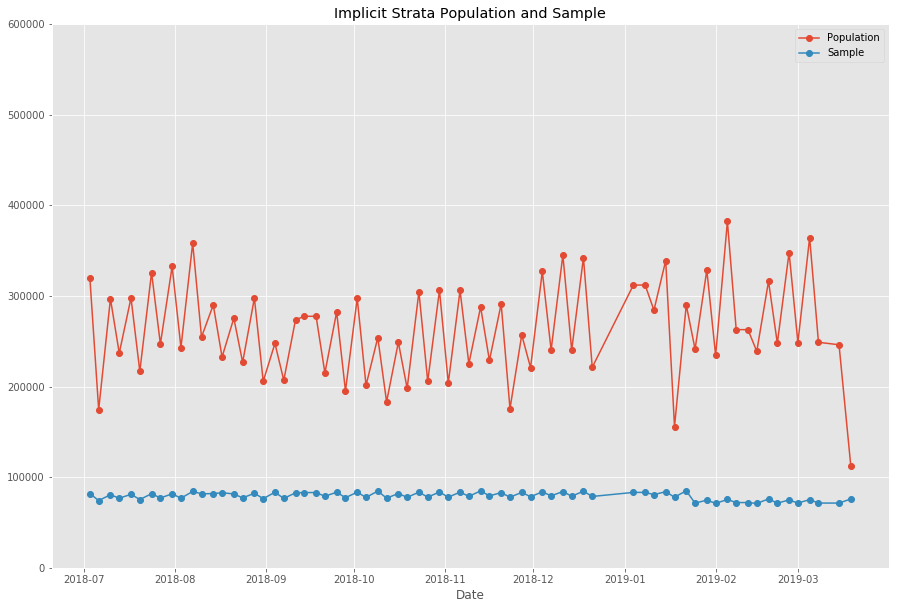

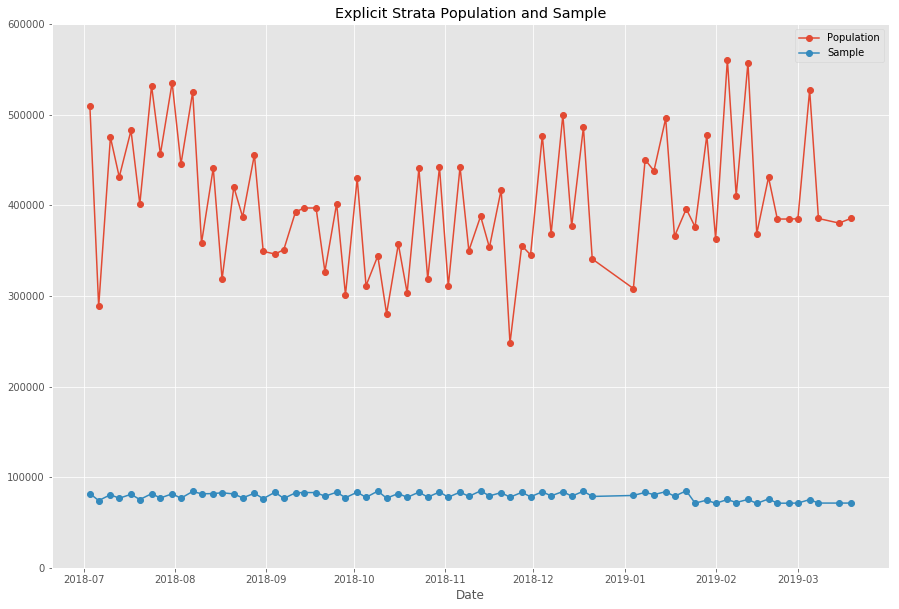

group       Explicit Strata > 30  Implicit Strata > 30
date                                                  
2018-07-03              0.306094              0.801754
2018-07-06              0.280269              0.701940
2018-07-10              0.308603              0.779514
2018-07-13              0.334377              0.784452
2018-07-17              0.301288              0.788831


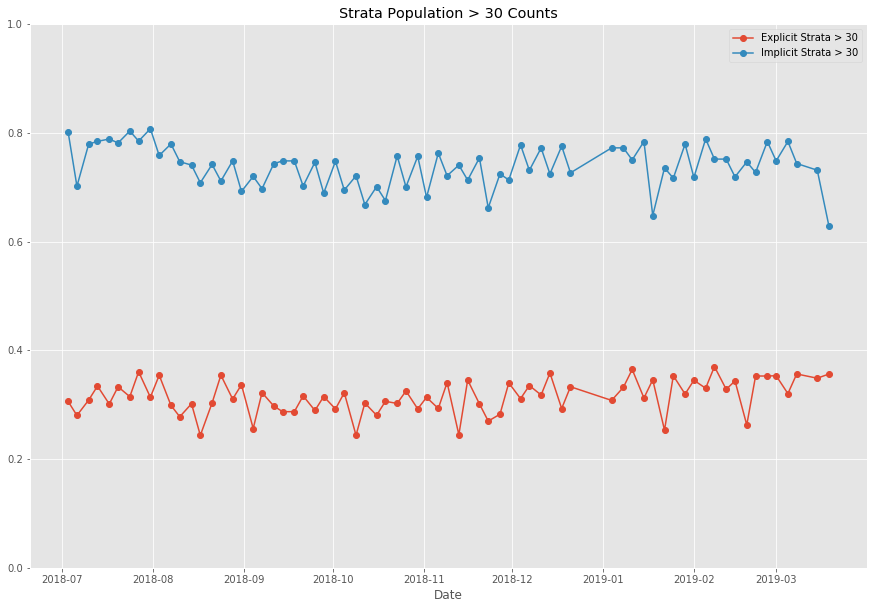

group       Explicit  Implicit
date                          
2018-07-03  0.207572  0.030635
2018-07-06  0.233968  0.015075
2018-07-10  0.216752  0.024499
2018-07-13  0.213223  0.018018
2018-07-17  0.223684  0.022124


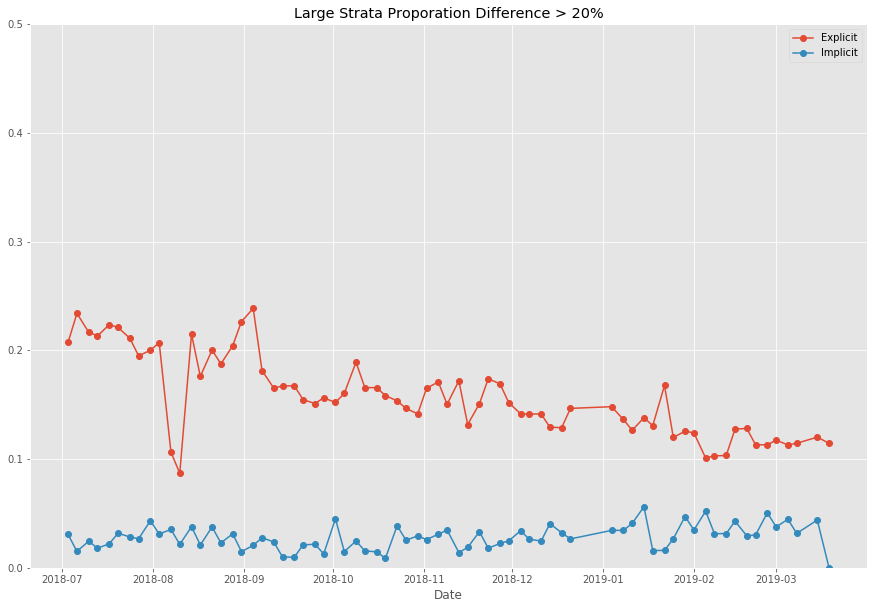

group       Eligible records  Rule 1 - Sampled for the previous week's MTM  \
date                                                                         
2018-07-03          0.711802                                      0.217610   
2018-07-06          0.691340                                      0.234654   
2018-07-10          0.716019                                      0.215930   
2018-07-13          0.623333                                      0.215513   
2018-07-17          0.629842                                      0.209260   

group       Rule 2 - MTM respondent in the previous 4 weeks  \
date                                                          
2018-07-03                                         0.070587   
2018-07-06                                         0.074005   
2018-07-10                                         0.068052   
2018-07-13                                         0.068756   
2018-07-17                                         0.066174   

group      

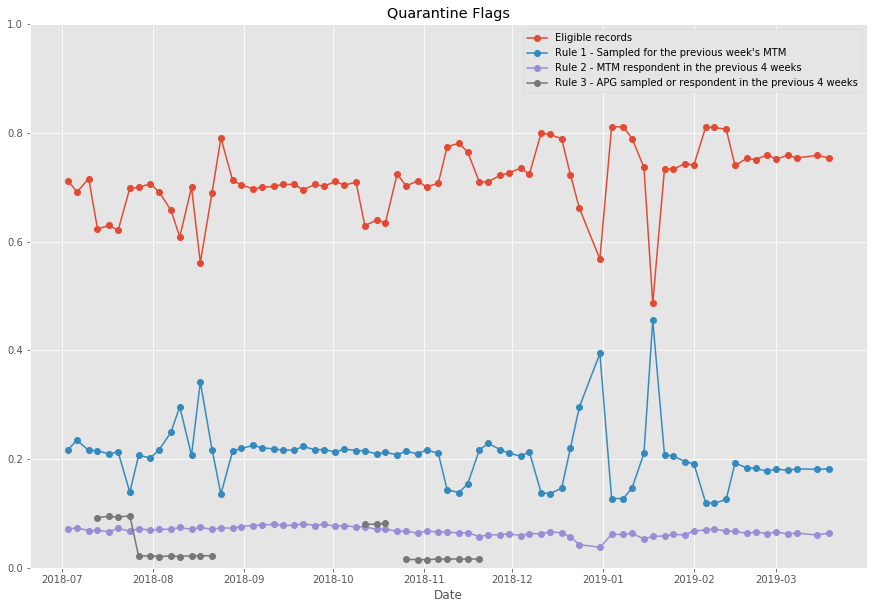

In [51]:
# call everything
data_dict = create_datasets(LOOPING_LIST, PARENT)
create_plots(data_dict)

In [5]:
data_dict.keys()

dict_keys(['raw_data_Implicit', 'Implicit_pop_resp', 'Implicit_over_30', 'Implicit_over_20', 'raw_data_Explicit', 'Explicit_pop_resp', 'Explicit_over_30', 'Explicit_over_20', 'raw_data_Quarantine', 'Quarantine'])

In [54]:
df = data_dict['raw_data_Implicit']
grp = 'State'
y = 'sample_distribution'
y_axis_lim = [0,.7]

# fix age grouping so that it's consistent across days
df['Age_Group'] = np.where((df['Age_Group'] == 'Age Group ( 60 - 69 )')|
                           (df['Age_Group'] == 'Age Group ( >= 70 )'),
                           'Age Group ( >= 60 )',df['Age_Group'])


In [63]:
# quality/date checker
def date_conversion(d):
    if d.isnull() == False:
        d.days
    else:
        d
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
for i in ['Implicit','Explicit']:
    data_dict['{}_pop_resp'.format(i)].sort_values(by=['date','group']).tail(50)
    df = pd.DataFrame({'sample_date' : sorted(data_dict['{}_pop_resp'.format(i)]['date'].unique())})
    df['previous_date'] = df.shift(1)
    df['days_between_sample'] = [d.days for d in df['sample_date'] - df['previous_date']]
    df['day_of_week'] = [days[d.weekday()] for d in df['sample_date']]

    print(df.day_of_week.value_counts())
    print(df[df['days_between_sample'] > 4])
    ## missing week of 
    ## 3/10: (3/12, 3/15)
    ## 12/23: (12/25, 12/28)

Fri     36
Tues    35
Mon      2
Name: day_of_week, dtype: int64
   sample_date previous_date  days_between_sample day_of_week
51  2018-12-31    2018-12-24                  7.0         Mon
71  2019-03-15    2019-03-08                  7.0         Fri
Fri     36
Tues    35
Mon      2
Name: day_of_week, dtype: int64
   sample_date previous_date  days_between_sample day_of_week
51  2018-12-31    2018-12-24                  7.0         Mon
71  2019-03-15    2019-03-08                  7.0         Fri


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


In [55]:
print(data_dict.keys())

dict_keys(['raw_data_Implicit', 'Implicit_pop_resp', 'Implicit_over_30', 'Implicit_over_20', 'raw_data_Explicit', 'Explicit_pop_resp', 'Explicit_over_30', 'Explicit_over_20', 'raw_data_Quarantine', 'Quarantine'])


To Do:
- Check to make sure that script is running the same as R
- Scaling
- Add new looks based on stats call (incorporate demographic info, etc)